In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [21]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subject_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}"""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return 
the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:
  * Take a user input topic
  * Produce a list of joke topics from it
  * Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation


In [29]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Subjects(BaseModel):
    """A class with a list of joke subjects"""
    subjects: list[str] = Field(description="We expect a list of 3 joke topics here")

class BestJoke(BaseModel):
    id: int

class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [30]:
def generate_topics(state: OverallState):
    prompt = subject_prompt.format(topic=state["topic"])
    print(prompt)
    response = model.with_structured_output(Subjects).invoke(prompt)
    print(response)
    static_topics = ["Hounds", "Monkeys", "Elefant"]
    return {"subjects": response.subjects}
    #return {"subjects": static_topics}

In [10]:
from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### Joke generation (map) -> generate_joke function

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`!

This key has a reducer that will combine lists

In [13]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

### Best joke selection (reduce step)

Now, we add logic to pick the best joke.

In [14]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke" : state["jokes"][response.id]}

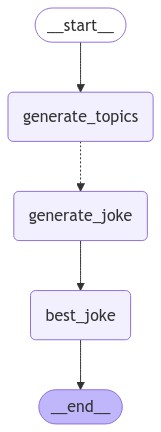

In [34]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START

graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [35]:
for s in app.stream({"topic": "animals"}):
    print(s)

Generate a list of 3 sub-topics that are all related to this overall topic: animals
subjects=['Pets', 'Wildlife', 'Marine Life']
{'generate_topics': {'subjects': ['Pets', 'Wildlife', 'Marine Life']}}
{'generate_joke': {'jokes': ['Why did the cat sit on the computer? Because it wanted to keep an eye on the mouse!']}}
{'generate_joke': {'jokes': ["Why don't you ever play hide and seek with a mountain lion? Because good luck hiding when it can 'puma' you in no time!"]}}
{'generate_joke': {'jokes': ["Why don't fish play piano? Because you can't tuna fish!"]}}
{'best_joke': {'best_selected_joke': "Why don't you ever play hide and seek with a mountain lion? Because good luck hiding when it can 'puma' you in no time!"}}
